# Konserveerunud sulgudega lauset

In [1]:
import csv
import pandas as pd
import json
from pathlib import Path

In [2]:
Path("./result/3_imgtrees").mkdir(parents=True, exist_ok=True) 
Path("./result/3_imgtrees/changed").mkdir(parents=True, exist_ok=True) 
Path("./result/3_imgtrees/conserved").mkdir(parents=True, exist_ok=True) 
Path("./result/3_imgtrees/constant").mkdir(parents=True, exist_ok=True) 

sentencesTSV = 'result/1_sentences_with_brackets.tsv'

df = pd.read_csv(sentencesTSV, sep='\t', header=None, quoting=csv.QUOTE_NONE)  
df.shape

(955564, 3)

In [3]:
df.head()

,0,1,2
0,0,484,Üks tolle õhtu süüdlasi oli kitarrist Sven Lõh...
1,1,152,Modelli ja modelliagentuuri omaniku Beatrice (...
2,1,429,Kui seni on Beatrice oma suhet DJ Priit Kuusik...
3,1,2906,Beatricel on Jürgen ( Jürgen Kaljuvee - toim )...
4,2,151,Eesti Kontserdi direktorile ja Arsise kellade ...


Ajame read juhuslikku järjekorda

In [4]:
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,0,1,2
0,367616,2775,Juhtusin valesse kohta pressikonverentsile ( E...
1,462084,245,Riigieelarvest saavad Riigikogu erakonnad sel ...
2,329934,12,Presidendivalimistel Arnold Rüütlile kaotanud ...
3,700238,2474,määruse ( EMÜ ) nr 2377/90 artiklis 8 sätestat...
4,58769,4823,1b küttearve samal ajal 9347 krooni ( üks tühi...


### 1000  juhuslikku sulgudega lauset

Laseme süntaksi peale.
Eemaldame sulgudega eraldatud lauseosa.
Laseme lühendatud lausele uuesti süntaksi peale.
Kontrollime, kas süntaks on konserveerunud.

In [5]:
import stanza
import os
from estnltk import Text
from estnltk.taggers.syntax.stanza_tagger.stanza_tagger import StanzaSyntaxTagger
from estnltk.converters.conll_exporter import  sentence_to_conll
import numpy as np


In [6]:
model_path = ".../estnltk-version_1.6/estnltk/taggers/syntax/stanza_tagger/stanza_resources"
model_path = '/Users/rabauti/stanza-models/stanza_recources'
input_type="morph_extended"
#stanza_tagger = StanzaSyntaxTagger(input_type=input_type, input_morph_layer=input_type, resources_path=model_path)
stanza_tagger = StanzaSyntaxTagger(input_type=input_type, input_morph_layer=input_type, add_parent_and_children=True, resources_path=model_path)


In [7]:
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.pyplot as plt
from collections import defaultdict
from textwrap import wrap
import networkx as nx

class graphFunctions:
    
    # tipu leidmine atribuudi väärtuse järgi
    def get_nodes_by_attributes(G,  attrname, attrvalue ):
        nodes = defaultdict(list)
        {nodes[v].append(k) for k, v in nx.get_node_attributes(G,attrname).items()}
        if attrvalue in nodes:
            return dict(nodes)[attrvalue]
        return []

    # graafi joonistamine 
    # tipp - lemma
    # serv - deprel
    
    #TODO params to **kwargs
    def drawGraph(G, title=None, filename=None, highlight=[]):
        
        # soovitud tipud punaseks
        color_map = ['red' if node in highlight else 'lightskyblue' for node in G]
        
        # joonise suurus, et enamik puudest ära mahuks
        plt.rcParams["figure.figsize"] = (18.5, 10.5)
        
        #pealkiri
        if title:
            title = ("\n".join(wrap( title, 120)))
            plt.title(title)
        
        pos = graphviz_layout(G, prog='dot')
        labels = nx.get_node_attributes(G, 'lemma')
        nx.draw(G, pos, cmap = plt.get_cmap('jet'),labels=labels, with_labels=True, node_color=color_map)
        edge_labels = nx.get_edge_attributes(G, 'deprel')
        nx.draw_networkx_edge_labels(G, pos, edge_labels)
        
        #kui failinimi, siis salvestame faili
        #kui pole, siis joonistame väljundisse
        if filename:
            plt.savefig(f'{filename}.png', dpi=100)
        else:
            plt.show()
        plt.clf()
    
    # conllu lause objektist graafi tegemine
    def make_graph_conllu(sentence):
        G = nx.DiGraph()
        for data in sentence:
            if isinstance(data['id'], int):
                #paneme graafi kokku
                G.add_node(data['id'], id=data['id'], lemma=data['lemma'], pos=data['upostag'], deprel=data['deprel'], form=data['form'])
                G.add_edge(data['id'] - data['id'] + data['head'], data['id'], deprel = data['deprel'])
        return G
    
    # stanza stanza_syntax objektist graafi tegemine
    def make_graph_stanza(sentence):
        G = nx.DiGraph()
        for data in sentence:
            #print (data)
            if isinstance(data['id'], int):
                #paneme graafi kokku
                G.add_node(data['id'], id=data['id'], lemma=data['lemma'], pos=data['upostag'], deprel=data['deprel'], form=data.text)
                G.add_edge(data['id'] - data['id'] + data['head'], data['id'], deprel = data['deprel'])
        return G

    # lyhim tee graafi tippude vahel ning nn reversed kaartega graafist sama
    def get_shortest_paths(G):

        # lyhim tee tippude vahel
        path = nx.all_pairs_shortest_path_length(G)
        path_reversed = nx.all_pairs_shortest_path_length(G.reverse())
        # kauguste maatriksid
        dpath = {x[0]:x[1] for x in path}
        dpath_reversed = {x[0]:x[1] for x in path}
        return {'dict': path,  'dict_reversed': path_reversed, 'matrix': dpath, 'matrix_reversed': dpath_reversed}

    #tagastab array-na syntaksipuu graafi propreteid, tippu 0 ignoreerib
    def get_prop(graph, property_name):
        return [graph.nodes[node][property_name] for node in sorted([node for node in graph.nodes]) if node]
    
    #leiab, millised tipud suuremast graafist1 on puudu graafis2
    def get_nodes_diff(graph1, graph2):
        return [ node for node in graph1 if not node in graph2 ]

In [8]:
        
def analyze_as_graph(text, stanza_tagger):
    #uus analüüs
    short_sent_txt = Text(text)
    short_sent_txt.analyse('all')
    stanza_tagger.tag(short_sent_txt)
    new_graph = graphFunctions.make_graph_stanza(short_sent_txt.stanza_syntax)
    return new_graph

#add blanks at position of indexes instead of removed words
def add_blanks(a, indexes, blank='_'):
    array=a.copy()
    for ind in sorted(indexes):   
        array.insert(ind-1, blank)
       
    return array

def remove_removed(a, indexes):
    #print (array, indexes)
    array=a.copy()
    for ind in reversed(sorted(indexes)):
        array.pop(ind-1)
    return array


def is_equal(arr1, arr2):
    if not len(arr1) == len(arr2):
        return False
    for i in range(len(arr1)):
        if not arr1[i] == arr2[i]:
            return False
    return True

def remove_brackets(inputG):
    
    G = inputG.copy()
    # eeldame, et sulud ( ) on peale tokeniseerimist eraldi lemmaks märgendatud
    # läbime Graafi tipud sõnade järjekorras, korjame kokku sellised nodeId
    # mis algavad ( ja lõpevad ) 
    # eemaldame, ei arvesta süntaksipuu struktuuriga, korjame kokku ainult nodeid-d
    
    
    leftNodes1 = []
    leftNodes2 = sorted([n for n in G.nodes])
    nodes_to_remove = []
    while not len(leftNodes1) == len(leftNodes2):
        
        in_b = False
        leftNodes1 = leftNodes2.copy()
        remove = []
        for n in leftNodes2:
            #ignoreerime null tippu
            if not n: continue
            token = G.nodes[n]['form']
            if not in_b and token == '(':
                remove.append(n)
                in_b = True
                continue
            elif in_b  and  token == '(':
                remove=[]
                remove.append(n)
                in_b = True
                continue
            elif in_b and token == ')':
                #print ('siin break', n, G.nodes[n]['lemma'])
                remove.append(n)
                in_b = False
                break
            elif in_b:
                #print ('siin', n, G.nodes[n]['lemma'])
                remove.append(n)
        #kui lõpeatavad sulgu ei tulnud
        if in_b:
            remove = []
        for n in remove:
            leftNodes2.remove(n) 
            nodes_to_remove.append(n)
        
        #print ('leftNodes1', len(leftNodes1))
        #print ('leftNodes2', len(leftNodes2))
        
        #print ('remove', remove)
    
    for n in nodes_to_remove:
        G.remove_node(n)
    
    return G


### testimiseks

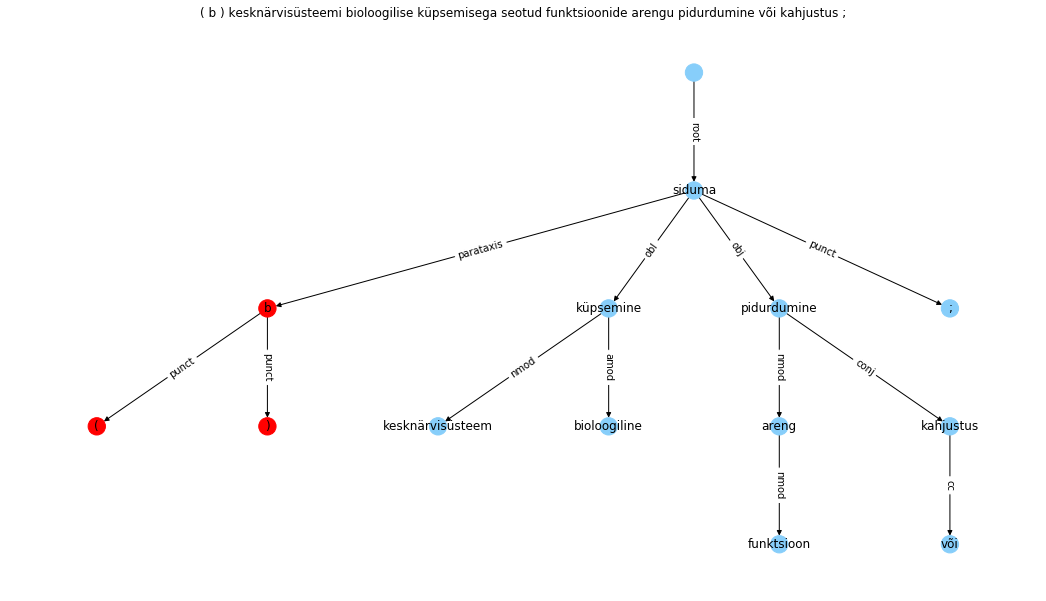

<Figure size 1332x756 with 0 Axes>

In [9]:
sentence = '( b ) kesknärvisüsteemi bioloogilise küpsemisega seotud funktsioonide arengu pidurdumine või kahjustus ;'
#originaallause analüüs
g_orig = analyze_as_graph(sentence, stanza_tagger)
deprel_origin = graphFunctions.get_prop(g_orig, 'deprel')
g_short = remove_brackets(g_orig)

nodes_diff = graphFunctions.get_nodes_diff(g_orig, g_short)
 
    
graphFunctions.drawGraph(g_orig, sentence, None, nodes_diff)


In [10]:
%%time

df = df.sample(frac=1).reset_index(drop=True)
df.head()

dprl = "brackets"

RESULTS_PATH = "./result/"


outChangedSentencesTSV = RESULTS_PATH+"3_changed_sentences_" + dprl + ".tsv"
outConservedSentencesTSV = RESULTS_PATH+"3_conserved_sentences_" + dprl + ".tsv"

outChanged = open(outChangedSentencesTSV, 'w', encoding='utf-8')
outConserved = open(outConservedSentencesTSV, 'w', encoding='utf-8')

# create the csv writer
wChanged = csv.writer(outChanged, delimiter='\t')
wConserved = csv.writer(outConserved, delimiter='\t')


count = 1000

# deprel to remove

sentences_count = 0
syntax_conserved = 0
syntax_changed = 0

all_changes = {}

wConserved.writerow(('COLLECTION', 'SPANSTART', 'TYPE', 'TEXT', ),)
wChanged.writerow(('COLLECTION', 'SPANSTART', 'TYPE', 'TEXT', ),)

emptyrow = ('', '', '', '', )
for ind in range(df.shape[0]):
    
    
    proc_txt_no = df[0][ind]
    sent_span_start = df[1][ind]
     
    sentence = df[2][ind]
        
    #originaallause analüüs
    g_orig = analyze_as_graph(sentence, stanza_tagger)
    deprel_origin = graphFunctions.get_prop(g_orig, 'deprel')

    #kontrollime, et sulud on sees?
    # siia kontroll, et advmod ikka sees
    #if not dprl in sent.deprel: continue

    sentences_count += 1

    #graphFunctions.drawGraph(g_orig, sentence)

    g_short = remove_brackets(g_orig)

    #kui tekst muutus, siis:
    #teeme uue lauseanalüüsi Stanzaga
    #teisendame graafiks
    #graafist küsime deprelid
    #print (sentence)
    nodes_diff = graphFunctions.get_nodes_diff(g_orig, g_short)
    filename = f'{proc_txt_no}_{sent_span_start}'
    
    short_text = " ".join(graphFunctions.get_prop(g_short, 'form'))
    if 1 in nodes_diff and len(short_text):
        short_text = short_text[0].upper() + short_text[1:]

   
    #graphFunctions.drawGraph(g_short, short_text )

    if short_text == sentence or short_text == '':
        graphFunctions.drawGraph(g_orig, sentence, f'result/3_imgtrees/constant/{filename}_O')
        pass
    #jäi samaks

    #print ('here')
    g_new = analyze_as_graph(short_text, stanza_tagger)
    #graphFunctions.drawGraph(g_new, short_text)


    deprel_new = graphFunctions.get_prop(g_new, 'deprel')
    depreln_new_with_blanks = add_blanks(deprel_new,nodes_diff)
        
    #if len(deprel_new) > 

    original_removed = remove_removed(deprel_origin, nodes_diff)
    
    conserved = is_equal(deprel_new, original_removed)

    if conserved:
        syntax_conserved +=1
    else:
        syntax_changed +=1
    #all_changes = {k: all_changes.get(k, 0) + result['changes'].get(k, 0) for k in set(all_changes) | set(result['changes'])}

    
    row1 = [str(proc_txt_no) \
                , str(sent_span_start) \
                , 'O'
                , sentence ]
    
    row2 = [str(proc_txt_no) \
                , str(sent_span_start) \
                , 'S'
                , short_text ]
    
    row3 = [str(proc_txt_no) \
                , str(sent_span_start) \
                , 'Odeprel'
                , " ".join(deprel_origin)]
    
    row4 = [str(proc_txt_no) \
                , str(sent_span_start) \
                , 'Sdeprel'
                , " ".join(depreln_new_with_blanks)]
   
    if not conserved:
        
        wChanged.writerow(row1)
        wChanged.writerow(row2)
        wChanged.writerow(row3)
        wChanged.writerow(row4)
        wChanged.writerow(emptyrow)
        graphFunctions.drawGraph(g_orig, sentence, f'result/3_imgtrees/changed/{filename}_O', nodes_diff)
        graphFunctions.drawGraph(g_new, short_text, f'result/3_imgtrees/changed/{filename}_S')
    else:
        wConserved.writerow(row1)
        wConserved.writerow(row2)
        wConserved.writerow(row3)
        wConserved.writerow(row4)
        graphFunctions.drawGraph(g_orig, sentence, f'result/3_imgtrees/conserved/{filename}_O', nodes_diff)
        #graphFunctions.drawGraph(g_new, short_text, f'results/3_imgtrees/conserved/{filename}_S')
        wConserved.writerow(emptyrow)

    if syntax_changed >= count: break 

outChanged.close()
outConserved.close()
print (f'Teisendatud {sentences_count} lauset.')
print (f'Kokku vaadati {ind+1} lauset.')
print (f'Süntaks konserveerunud {syntax_conserved} lausel.')
print (f'Süntaks ei konserveerunud {syntax_changed} lausel.')

print (all_changes)

  

Teisendatud 2408 lauset.
Kokku vaadati 2408 lauset.
Süntaks konserveerunud 1408 lausel.
Süntaks ei konserveerunud 1000 lausel.
{}
CPU times: user 23min 29s, sys: 3min 7s, total: 26min 36s
Wall time: 37min 17s


<Figure size 1332x756 with 0 Axes>

In [11]:

dfChanged = pd.read_csv(outChangedSentencesTSV, sep='\t', quotechar = '"')  
dfChanged.shape

(5000, 4)

In [12]:
dfChanged.head()

,COLLECTION,SPANSTART,TYPE,TEXT
0,9107.0,1347.0,O,"Veerandfinaal : Norman - Nicolas Lapentti ( Ekuador , 3 ) 6 : 1 , 6 : 4."
1,9107.0,1347.0,S,"Veerandfinaal : Norman - Nicolas Lapentti 6 : 1 , 6 : 4."
2,9107.0,1347.0,Odeprel,root punct parataxis punct conj flat punct parataxis punct nummod punct nummod punct flat punct flat
3,9107.0,1347.0,Sdeprel,root punct parataxis punct conj flat _ _ _ _ _ nummod punct flat punct parataxis
4,NaN,NaN,NaN,NaN
